# Experiment 01: Baseline CNN

## Overview
This notebook establishes a baseline performance metric for age estimation from handwriting using a custom, lightweight Convolutional Neural Network (CNN).

**Architecture:**
* **Structure:** 3 Convolutional blocks (32, 64, 128 filters) followed by Max Pooling.
* **Head:** Flatten -> Dense (128) -> Dropout -> Output (1).
* **Input:** 128x128 RGB images.

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


In [ ]:
# --- Configuration ---
CONFIG = {
    "IMG_SIZE": (128, 128),
    "BATCH_SIZE": 32,
    "EPOCHS": 50,
    "LEARNING_RATE": 1e-3,
    "DROPOUT_RATE": 0.5,
    # Update these paths to match your local environment
    "DATA_DIR": "../data",  
    "CSV_PATH": "../data/NewAgeSplit.csv",
    "MODEL_SAVE_PATH": "./results/experiment_01_model.keras"
}

# Create model directory if it doesn't exist
os.makedirs(os.path.dirname(CONFIG["MODEL_SAVE_PATH"]), exist_ok=True)

## 1. Data Loading & Preprocessing
We load images directly into NumPy arrays and normalize pixel values to [0, 1]. 
Target labels (Age) are scaled using `MinMaxScaler` to stabilize training convergence.

In [35]:
def load_images_and_labels(data_dir, dataset_type, labels_df):
    """
    Loads images, corresponding age labels, and filenames.
    """
    subset_df = labels_df[labels_df['Set'] == dataset_type]
    images = []
    labels = []
    filenames = []  # New list to store filenames

    print(f"Loading {dataset_type} data...")
    
    # Check if directory exists
    target_dir = os.path.join(data_dir, dataset_type)
    if not os.path.exists(target_dir):
        raise FileNotFoundError(f"Directory not found: {target_dir}")

    for _, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc=f"Processing {dataset_type}"):
        img_path = os.path.join(target_dir, row['File'])
        
        if os.path.exists(img_path):
            try:
                # Load and preprocess
                img = tf.keras.utils.load_img(img_path, target_size=CONFIG["IMG_SIZE"])
                img = tf.keras.utils.img_to_array(img) / 255.0  # Normalize [0,1]
                images.append(img)
                labels.append(row['Age'])
                filenames.append(row['File']) # Store the filename
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        else:
            # Optional: Warning for missing files
            pass

    # Return filenames as the 3rd output
    return np.array(images), np.array(labels), np.array(filenames)

In [36]:
# Load Metadata
if os.path.exists(CONFIG["CSV_PATH"]):
    labels_data = pd.read_csv(CONFIG["CSV_PATH"])
    
    # Load Datasets (Now unpacking 3 values)
    X_train, y_train_raw, train_files = load_images_and_labels(CONFIG["DATA_DIR"], 'train', labels_data)
    X_val, y_val_raw, val_files = load_images_and_labels(CONFIG["DATA_DIR"], 'val', labels_data)
    X_test, y_test_raw, test_files = load_images_and_labels(CONFIG["DATA_DIR"], 'test', labels_data)
    
    print(f"\nDataset Shapes:")
    print(f"Train: {X_train.shape}")
    print(f"Val:   {X_val.shape}")
    print(f"Test:  {X_test.shape}")
else:
    print(f"Error: CSV not found at {CONFIG['CSV_PATH']}")

Loading train data...


Processing train: 100%|██████████| 10/10 [00:00<00:00, 35.20it/s]


Loading val data...


Processing val: 100%|██████████| 5/5 [00:00<00:00, 34.73it/s]


Loading test data...


Processing test: 100%|██████████| 5/5 [00:00<00:00, 46.37it/s]


Dataset Shapes:
Train: (10, 128, 128, 3)
Val:   (5, 128, 128, 3)
Test:  (5, 128, 128, 3)


In [21]:
# Normalize labels using MinMaxScaler
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
y_val = scaler.transform(y_val_raw.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test_raw.reshape(-1, 1)).flatten()

print(f"Labels scaled to range: {y_train.min()} - {y_train.max()}")

Labels scaled to range: 0.0 - 1.0


## 2. Model Architecture
We define a Sequential CNN with increasing filter depth (32 -> 64 -> 128) to capture hierarchical features of the handwriting.

In [22]:
def build_model(input_shape):
    model = Sequential([
        # Block 1: Spatial features
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), 
        MaxPooling2D((2, 2)), 
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Regression Head
        Flatten(),
        Dense(128, activation='relu'), 
        Dropout(CONFIG["DROPOUT_RATE"]), 
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model((CONFIG["IMG_SIZE"][0], CONFIG["IMG_SIZE"][1], 3))
model.summary()

c:\Users\liora\OneDrive\Documents\Important\School\Final Project\Age_Estimation\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Training
We utilize `ImageDataGenerator` for real-time augmentation on the training set to improve generalization. The validation set remains untouched.

In [23]:
# Augmentation for training only
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator() # No augmentation for val
test_datagen = ImageDataGenerator() # No augmentation for test

# Generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=CONFIG["BATCH_SIZE"])
val_generator = val_datagen.flow(X_val, y_val, batch_size=CONFIG["BATCH_SIZE"])
test_generator = test_datagen.flow(X_test, y_test, batch_size=CONFIG["BATCH_SIZE"], shuffle=False)

# Checkpoint to save best model
checkpoint = ModelCheckpoint(
    CONFIG["MODEL_SAVE_PATH"], 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min',
    verbose=1
)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=CONFIG["EPOCHS"],
    callbacks=[checkpoint]
)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4373 - mae: 0.5453
Epoch 1: val_loss improved from None to 217.34009, saving model to ./models/experiment_01_baseline.keras

Epoch 1: finished saving model to ./models/experiment_01_baseline.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4373 - mae: 0.5453 - val_loss: 217.3401 - val_mae: 14.6871
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 165.4240 - mae: 12.5763
Epoch 2: val_loss improved from 217.34009 to 11.90514, saving model to ./models/experiment_01_baseline.keras

Epoch 2: finished saving model to ./models/experiment_01_baseline.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 165.4240 - mae: 12.5763 - val_loss: 11.9051 - val_mae: 3.4419
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 3.3367 - mae: 1.6680
Epoch 3: val_loss improved from 11.90514 to 0.40163, saving model to ./models/experiment_01_baseline.keras

Epoch 3: finished saving model to ./models/experiment_01_baseline.keras
1/1 ━━━━━

## 4. Evaluation
We load the best performing model from the training phase and evaluate it against the Test set. Predictions are inverse-transformed to get the real age values (years).

In [24]:
# Load the best model
best_model = tf.keras.models.load_model(CONFIG["MODEL_SAVE_PATH"])

# Predict
print("Generating predictions...")
predictions_scaled = best_model.predict(test_generator)

# Denormalize
predictions_years = scaler.inverse_transform(predictions_scaled).flatten()
# y_test_raw is already in years (from Cell 5)

# Calculate Metrics
mae = np.mean(np.abs(y_test_raw - predictions_years))
rmse = np.sqrt(mean_squared_error(y_test_raw, predictions_years))
r2 = r2_score(y_test_raw, predictions_years)
mape = np.mean(np.abs((y_test_raw - predictions_years) / y_test_raw)) * 100

# Accuracy Thresholds
errors = np.abs(y_test_raw - predictions_years)
within_2 = np.mean(errors <= 2) * 100
within_5 = np.mean(errors <= 5) * 100
within_10 = np.mean(errors <= 10) * 100
max_error = np.max(errors)
median_error = np.median(errors)
min_error = np.min(errors)

print(f"\n--- Final Results (Baseline CNN) ---")
print(f"MAE:  {mae:.2f} years")
print(f"RMSE: {rmse:.2f} years")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy (±2 years):  {within_2:.2f}%")
print(f"Accuracy (±5 years):  {within_5:.2f}%")
print(f"Accuracy (±10 years): {within_10:.2f}%")
print(f"Max Error:    {max_error:.2f} years")
print(f"Median Error: {median_error:.2f} years")
print(f"Min Error:    {min_error:.2f} years")

Generating predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

--- Final Results (Baseline CNN) ---
MAE:  12.68 years
RMSE: 13.39 years
R²:   -8.3375
MAPE: 68.37%
Accuracy (±2 years):  0.00%
Accuracy (±5 years):  0.00%
Accuracy (±10 years): 40.00%
Max Error:    19.51 years
Median Error: 13.23 years
Min Error:    6.75 years


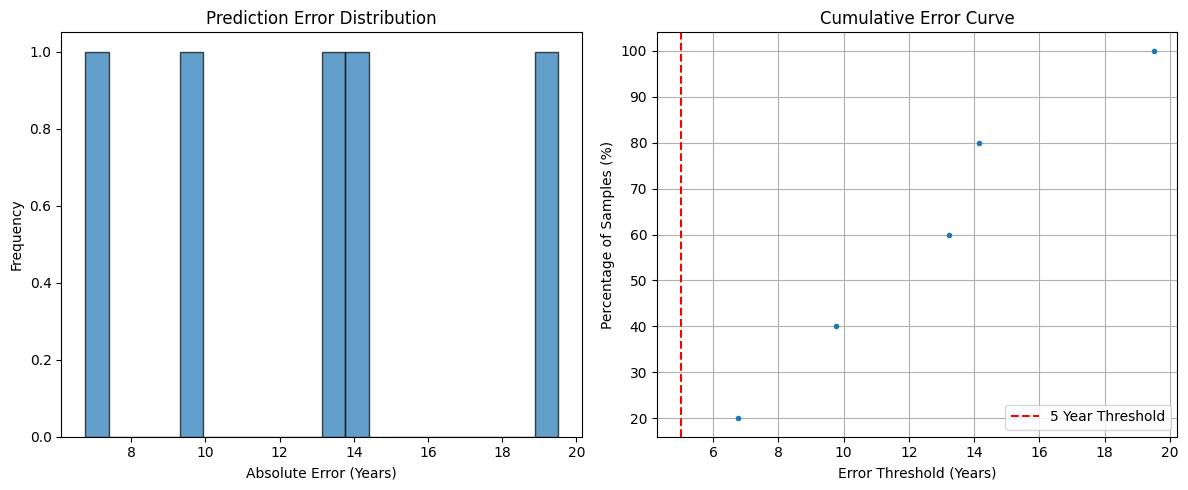

In [25]:
plt.figure(figsize=(12, 5))

# Plot 1: Error Distribution
plt.subplot(1, 2, 1)
plt.hist(errors, bins=20, edgecolor='black', alpha=0.7)
plt.title('Prediction Error Distribution')
plt.xlabel('Absolute Error (Years)')
plt.ylabel('Frequency')

# Plot 2: Cumulative Error
plt.subplot(1, 2, 2)
errors_sorted = np.sort(errors)
cumulative_percentage = np.arange(1, len(errors_sorted) + 1) / len(errors_sorted) * 100
plt.plot(errors_sorted, cumulative_percentage, marker='.', linestyle='none')
plt.title('Cumulative Error Curve')
plt.xlabel('Error Threshold (Years)')
plt.ylabel('Percentage of Samples (%)')
plt.grid(True)
plt.axvline(x=5, color='r', linestyle='--', label='5 Year Threshold')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# --- Save Predictions to CSV ---

# Create a DataFrame
results_df = pd.DataFrame({
    'Image': test_files,
    'True Age': y_test_raw,
    'Predicted Age': np.round(predictions_years, 2)  # Rounded for readability
})

# Define save path
results_save_path = "./models/experiment_01_predictions.csv"

# Save to CSV
results_df.to_csv(results_save_path, index=False)
print(f"\nPredictions saved to: {results_save_path}")

# Display first few rows to verify
print(results_df.head())


Predictions saved to: ./models/experiment_01_predictions.csv
                Image  True Age  Predicted Age
0  w14_F_2_form19.tif        20      34.139999
1  w16_M_3_form21.tif        27      33.750000
2  w17_F_2_form22.tif        24      33.759998
3  w19_M_2_form25.tif        20      33.230000
4   w43_F_1_form4.tif        14      33.509998
